## Text Classification

**Product Review (2016-2021)** <br/>

In this assignment I will perform review classification on the product review dataset which was collected and parsed in the previous task.

This notebook covers **Task 2 - Review Sentiment Classification** and **Task 3 - Review Helpfulness Classification**. Since the raw data is in CSV format so I will convert it into a more appropriate dataframe form and then I will perform cleaning and analysis procedures.

In [1]:
import pandas as pd
import numpy as np
import string
import os
import re
import requests
import seaborn as sn
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

from nltk.tokenize import WordPunctTokenizer
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, RepeatedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')


In [2]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Task 2 - Review Sentiment Classification:

## Data Preparation

### Data Loading:

Function to load the CSV file (raw data) from the previous task and then to parse it into the pandas dataframe

In [3]:
df = pd.read_csv("raw/review_data.csv")

In [4]:
df.head(5)

,Title,Review,Rating,Helpfulness_Info
0,This filter works PERFECT!,"Seriously, I love my Keurig. I love the conven...",5,472 out of 477 users found this review helpful
1,This stuff is great for muffins,There's a recipe on the back of the package fo...,4,17 out of 17 users found this review helpful
2,Curiously awful,Cola is by far my favorite drink. My wife and ...,1,1 out of 14 users found this review helpful
3,Rancid!,"I love chia, but I have gotten two different p...",1,23 out of 26 users found this review helpful
4,They taste like boogers,"If you don't like the sound of a salty, vinega...",1,4 out of 19 users found this review helpful


### Data Cleaning:

Now, I will assign a class label (positive or negative) to each review where 1-star to 3-star ratings will be assumed negative and 4-star to 5-star to be positive.

In [5]:
df['Rating'] = df['Rating'].apply(lambda x: "Positive" if x > 3 else "Negative")

In [6]:
df.head(5)

,Title,Review,Rating,Helpfulness_Info
0,This filter works PERFECT!,"Seriously, I love my Keurig. I love the conven...",Positive,472 out of 477 users found this review helpful
1,This stuff is great for muffins,There's a recipe on the back of the package fo...,Positive,17 out of 17 users found this review helpful
2,Curiously awful,Cola is by far my favorite drink. My wife and ...,Negative,1 out of 14 users found this review helpful
3,Rancid!,"I love chia, but I have gotten two different p...",Negative,23 out of 26 users found this review helpful
4,They taste like boogers,"If you don't like the sound of a salty, vinega...",Negative,4 out of 19 users found this review helpful


Helpfulness Information also needs to be transformed into binary labels as "Helpful" or "Unhelpful". I will assign a "Helpful" label to the reviews where atleast 80% of the users found it helpful otherwise "Unhelpful"

In [8]:
df['Helpfulness_Info'] = df['Helpfulness_Info'].apply(lambda x: x.replace(" users found this review helpful",""))


In [9]:
df['Helpfulness_Info'] = df['Helpfulness_Info'].apply(lambda x: x.replace(" out of ","/"))


In [10]:
df['Helpfulness_Info'] = df['Helpfulness_Info'].apply(lambda x: "Helpful" if int(x.split("/")[0])/int(x.split("/")[1]) > 0.8 else "Unhelpful")


In [11]:
df.head(5)

,Title,Review,Rating,Helpfulness_Info
0,This filter works PERFECT!,"Seriously, I love my Keurig. I love the conven...",Positive,Helpful
1,This stuff is great for muffins,There's a recipe on the back of the package fo...,Positive,Helpful
2,Curiously awful,Cola is by far my favorite drink. My wife and ...,Negative,Unhelpful
3,Rancid!,"I love chia, but I have gotten two different p...",Negative,Helpful
4,They taste like boogers,"If you don't like the sound of a salty, vinega...",Negative,Unhelpful


After assigning the appropriate labels for rating and helpfulness information columns, I will concatenate the title and the review body text columns together in a new column and create a set of text documents for further analysis. 

In [12]:
df['text'] = df[['Title', 'Review']].apply(lambda x: ' '.join(x), axis=1)

In [13]:
df.head(5)

,Title,Review,Rating,Helpfulness_Info,text
0,This filter works PERFECT!,"Seriously, I love my Keurig. I love the conven...",Positive,Helpful,"This filter works PERFECT! Seriously, I love m..."
1,This stuff is great for muffins,There's a recipe on the back of the package fo...,Positive,Helpful,This stuff is great for muffins There's a reci...
2,Curiously awful,Cola is by far my favorite drink. My wife and ...,Negative,Unhelpful,Curiously awful Cola is by far my favorite dri...
3,Rancid!,"I love chia, but I have gotten two different p...",Negative,Helpful,"Rancid! I love chia, but I have gotten two dif..."
4,They taste like boogers,"If you don't like the sound of a salty, vinega...",Negative,Unhelpful,They taste like boogers If you don't like the ...


In [14]:
transformed_df = df[['text', 'Rating', 'Helpfulness_Info']].copy()

In [15]:
transformed_df.head()

,text,Rating,Helpfulness_Info
0,"This filter works PERFECT! Seriously, I love m...",Positive,Helpful
1,This stuff is great for muffins There's a reci...,Positive,Helpful
2,Curiously awful Cola is by far my favorite dri...,Negative,Unhelpful
3,"Rancid! I love chia, but I have gotten two dif...",Negative,Helpful
4,They taste like boogers If you don't like the ...,Negative,Unhelpful


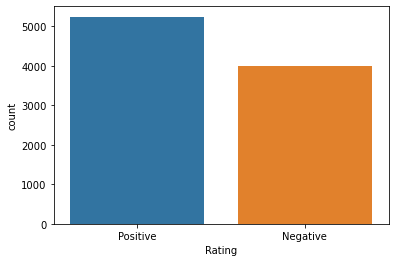

In [16]:
sn.countplot(transformed_df['Rating'])
plt.show()

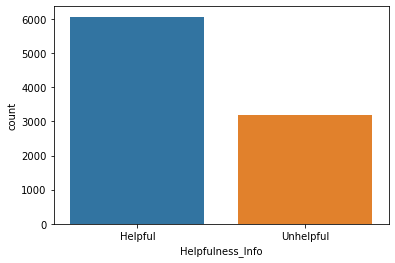

In [17]:
sn.countplot(transformed_df['Helpfulness_Info'])
plt.show()

Now, I have successfully cleaned the raw csv data into more usable text documents with rating and helpfulness labels. These frames will be fed into the pre processing step to transform it into a numeric representation, suitable for classification.

### Data Pre - Processing:

__Pre-Processing:__

Following pre-processing and feature engineering steps will be applied on the data:

    1. Normalization
    1. Lemmatization
    2. Stopword removal
    3. Minimum document frequency
    4. TF-IDF Vectorization

Function to normalize the text data which includes changing text to lower case and removal of punctuation.

In [18]:
# Normalisation Step
def normalize_data(df):
    for i in range(len(df)):
        df.loc[i,'text'] = "".join([word.lower() for word in df.loc[i,'text'] if word not in string.punctuation])
    return df

__Lemmatization:__

There are two approaches for finding the root form of a word as below:

    i. Stemming 
    ii. Lemmatization
    
 __Stemming__ is a rudimentary procedure that cuts off the ends of words in the expectation of accomplishing this objective,but often leads to incorrect meanings and spellings. __Lemmatization__ is a term that refers to doing things correctly via the use of a vocabulary and morphological study of words, with the goal of removing only inflectional ends and returning a word to its base or meaningful form.
 
Therefore, the below function would make use of WordNetLemmatizer to pre-process the documents 

In [19]:
# Lemmatisation Step
def lemmatize_data(df):
    lemmatizer = WordNetLemmatizer()
    for i in range(len(df)):
        df.loc[i,'text'] = lemmatizer.lemmatize(df.loc[i,'text'])
    return df

In [20]:
normalized_df = normalize_data(transformed_df)
lemmatized_df = lemmatize_data(normalized_df)

In [21]:
lemmatized_df.head(5)

,text,Rating,Helpfulness_Info
0,this filter works perfect seriously i love my ...,Positive,Helpful
1,this stuff is great for muffins theres a recip...,Positive,Helpful
2,curiously awful cola is by far my favorite dri...,Negative,Unhelpful
3,rancid i love chia but i have gotten two diffe...,Negative,Helpful
4,they taste like boogers if you dont like the s...,Negative,Unhelpful


__Stop Word Removal:__

This is a pre-processing technique to remove the commonly used words in any language. For instance, prepositions, determinars in English Language. These words do not convey any meaning and they don't help in adding any context to the text document.


__Minimum Document Frequency:__

`min_df` is used for removing terms that appear less frequently. I am setting this value as 5 because the corpus is not too large.

__NGram Range:__

`ngram_range` is used for providing a upper and lower range for ngram considerations while creating the vector matrix. I have selected upto bigrams because certain words always occur together.


__TF-IDF Vectorization:__

`Tf-idf` stands for term frequency-inverse document frequency. This calculates the term frequency in a particular document and the overall corpus and weights more for the terms which are infrequent overall.

Rather than using `countVectorizer` to convert a collection of text documents to a matrix of token counts and then applying idf score to find `tf-idf` This can be achieved directly using __TfidfVectorizer__.
Similarly there is __Word2Vec__ which allows mapping of similar meaning words to have similar vector matrix


In [22]:
# Running the Tf-IDF Vectorizer with stop word removal, minimum document frequency and n-gram range of 2
vectorizerModel = TfidfVectorizer(stop_words="english",min_df=5,ngram_range=(1, 2))

# Storing review text and rating labels separately
reviewDocuments = lemmatized_df['text'].tolist()
rating_labels = lemmatized_df['Rating'].tolist()
helpfulness_labels = lemmatized_df['Helpfulness_Info'].tolist()

# Generating TF-IDF matrix
vectorized_df = vectorizerModel.fit_transform(reviewDocuments)
rating_df = pd.DataFrame(vectorized_df.todense(), columns = vectorizerModel.get_feature_names())
rating_df['Label'] = rating_labels

helpfulness_df = pd.DataFrame(vectorized_df.todense(), columns = vectorizerModel.get_feature_names())
helpfulness_df['Label'] = helpfulness_labels

# Distinct terms in the review
terms = vectorizerModel.get_feature_names()
print("Reviews in {} has {} distinct terms" .format("vectorized dataframe",len(terms)))


Reviews in vectorized dataframe has 29387 distinct terms


In [23]:
rating_df.head(5)

,00004,00004 brita,0014,0014 sodastream,00373,00373 water,00377,00377 assumes,018,018 water,...,zoloft really,zone,zp,zp bowl,zp canned,zp close,zp figuring,zucchini,zukes,Label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Positive
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Positive
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Negative
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Negative
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Negative


Now, I have successfully pre-processed the text documents and created two different dataframes, one with rating labels and other with helpfulness labels.

### Review Sentiment Classification:

__Training and Testing Datasets__

Using `train_test_split` function with a splitting criteria of 70%-30% to generate trainig and testing datasets for the sentiment classification.

In [24]:
X_train, X_test, y_train, y_test = train_test_split(rating_df.iloc[:,:-1], rating_df.iloc[:,-1], test_size=0.30)


Reviewing the distribution of labels within the training dataset

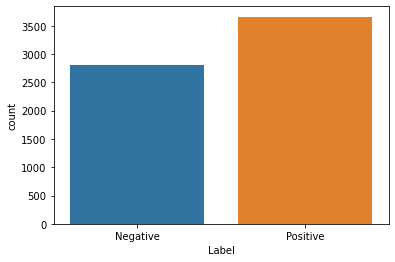

In [25]:
sn.countplot(y_train)
plt.show()

__Building Classification Models__

Generating models using multiple classification algorithms together and then plotting accuracy results to see which one performs better. 
- Random Forest
- K Nearest Neighbours
- Linear Support Vector
- Decision Tree
- Multinomial Naive Bayes
- Logictic Regression

In [26]:
def classifier_mixup(dataframe):
    # Defining six different classification models
    models = [
        RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
        KNeighborsClassifier(n_neighbors=3),
        LinearSVC(),
        DecisionTreeClassifier(),
        MultinomialNB(),
        LogisticRegression(random_state=0)]

    # Defining variables
    cvdf = pd.DataFrame(index = range(5 * len(models)))
    figures = []

    # Running models and calculating accuracies using cross val score with cv as 5
    for model in models:
        model_name = model.__class__.__name__
        cvs = cross_val_score(model, dataframe.iloc[:,:-1], dataframe.iloc[:,-1], scoring='accuracy', cv=5)
        for num_f, accuracy in enumerate(cvs):
            figures.append((model_name, num_f, accuracy))

    cvdf = pd.DataFrame(figures, columns=['model_name', 'num_f', 'accuracy'])
    
    # Creating a strip plot with accuracies from all the models
    fig, ax = plt.subplots(figsize=(25,15))
    sn.boxplot(x='model_name', y='accuracy', data=cvdf, ax=ax)
    sn.stripplot(x='model_name', y='accuracy', data=cvdf, size=15, jitter=True, edgecolor="gray", linewidth=2, ax=ax)
    plt.title("Model Accuracy Comparison", fontsize=15)
    plt.rcParams.update({'font.size': 10})
    plt.show()
    
    return cvdf

Note: Running the below step would take a few minutes (6-7 minutes) because it trains and calculates the accuracy for various classification models together

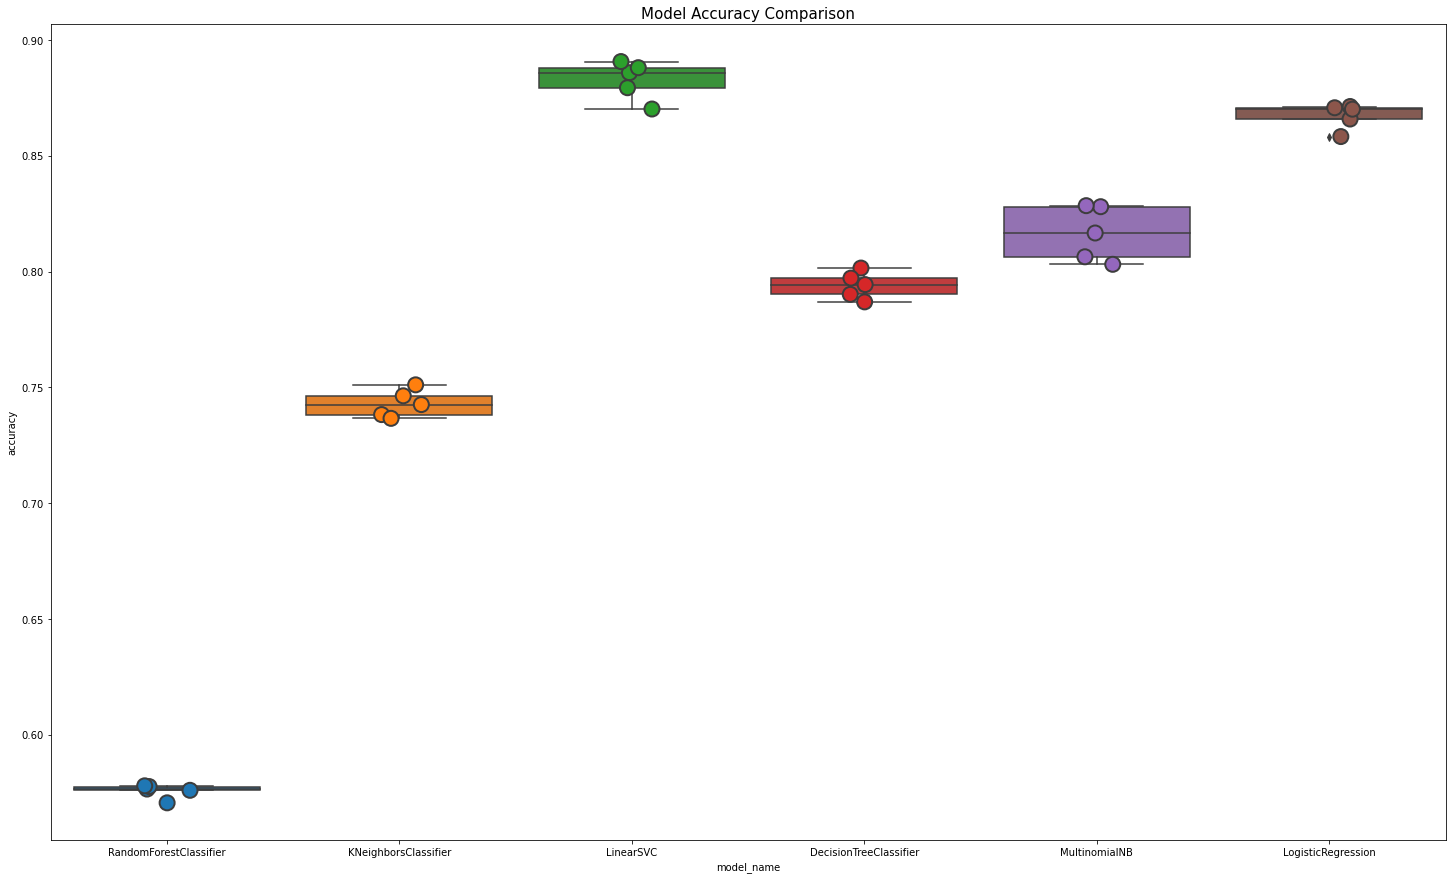

In [27]:
cvdf = classifier_mixup(rating_df)

In [28]:
# Mean accuarcy per model
cvdf.groupby('model_name').accuracy.mean()

model_name
DecisionTreeClassifier    0.794029
KNeighborsClassifier      0.742969
LinearSVC                 0.882844
LogisticRegression        0.867266
MultinomialNB             0.816531
RandomForestClassifier    0.575725
Name: accuracy, dtype: float64

The plot and the mean accuracy table above shows that the __Linear Support Vector Machine__ performs best amongst all the models followed by __Logistic Regression__ Model.

__Logistic Regression Model__

It uses weighted combination of features and then passes it into the sigmoid function.

In [29]:
# Building and training the classifier
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

# Testing the classifier
y_pred = lr_model.predict(X_test)

# Accuracy
chk_acc = accuracy_score(y_pred, y_test)
print('Accuracy Score with Logistic Regression:{} \n'.format(chk_acc*100))

Accuracy Score with Logistic Regression:85.40014419610671 



Classification Report for Logistic Regression Model:
              precision    recall  f1-score   support

    Negative       0.88      0.76      0.82      1189
    Positive       0.84      0.93      0.88      1585

    accuracy                           0.85      2774
   macro avg       0.86      0.84      0.85      2774
weighted avg       0.86      0.85      0.85      2774



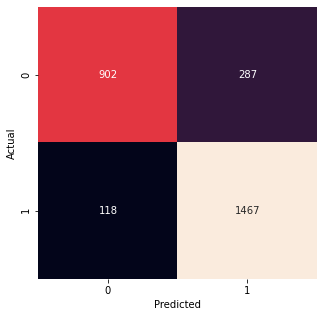

In [30]:
# Creating confusion matrix and classification report for the model
con_mat = confusion_matrix(y_test, y_pred)
creport = classification_report(y_test, y_pred)
print("Classification Report for Logistic Regression Model:\n{}".format(creport))

# Plotting the results
fig, ax = plt.subplots(figsize=(5,5))
sn.heatmap(con_mat, annot=True, cbar = False, fmt = 'd')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

__Linear Stochastic Gradient Descent__

Linear SGD and Linear SVC are widely considered as the best text classification algorithms. It is so because text is often linearly separable and they have a lot of features making it high dimension.

In [31]:
# Building and training the classifier
sgd_model = SGDClassifier()
sgd_model.fit(X_train, y_train)

# Testing the classifier
y_pred = sgd_model.predict(X_test)

# Accuracy
chk_acc = accuracy_score(y_pred, y_test)
print('Accuracy Score with Linear SGD:{} \n'.format(chk_acc*100))

Accuracy Score with Linear SGD:87.41888968997837 



Using `Pipeline` to implement the SGD classification model which uses different pre processing techniques as `Count Vectorizer` and `TF-IDF Transformer`

In [32]:
pipeline_sgd = Pipeline([('vec', CountVectorizer(stop_words="english")),
                    ('tfidf', TfidfTransformer(use_idf=True)),
                    ('clf', SGDClassifier())
                    ])
acc_scores = cross_val_score(pipeline_sgd, lemmatized_df.iloc[:,0], lemmatized_df.iloc[:,1],
cv=10, scoring="accuracy")

print("Overall mean accuracy with Linear SGD:%.2f" %acc_scores.mean())

Overall mean accuracy with Linear SGD:0.88


Both general SGD classifier and the pipeline implementation for sgd classifiers are performing similarly in terms of their accuracy scores.

Classification Report for SGD Classification Model:
              precision    recall  f1-score   support

    Negative       0.87      0.83      0.85      1189
    Positive       0.88      0.90      0.89      1585

    accuracy                           0.87      2774
   macro avg       0.87      0.87      0.87      2774
weighted avg       0.87      0.87      0.87      2774



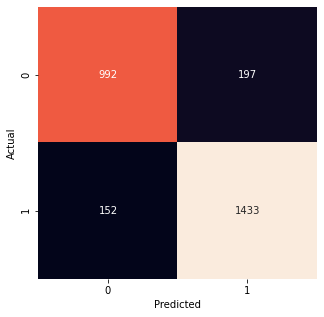

In [33]:
# Creating confusion matrix and classification report for the model
con_mat = confusion_matrix(y_test, y_pred)
creport = classification_report(y_test, y_pred)
print("Classification Report for SGD Classification Model:\n{}".format(creport))

# Plotting the results
fig, ax = plt.subplots(figsize=(5,5))
sn.heatmap(con_mat, annot=True, cbar = False, fmt = 'd')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

__Linear Support Vector Machine__

In [34]:
# Building and training the classifier
svc_model = LinearSVC()
svc_model.fit(X_train, y_train)

# Testing the classifier
y_pred = svc_model.predict(X_test)

# Accuracy
chk_acc = accuracy_score(y_pred, y_test)
print('Accuracy Score with Linear Support Vector Machine:{} \n'.format(chk_acc*100))

Accuracy Score with Linear Support Vector Machine:87.7072819033886 



Classification Report for Support Vector Machine Model:
              precision    recall  f1-score   support

    Negative       0.87      0.83      0.85      1189
    Positive       0.88      0.91      0.89      1585

    accuracy                           0.88      2774
   macro avg       0.88      0.87      0.87      2774
weighted avg       0.88      0.88      0.88      2774



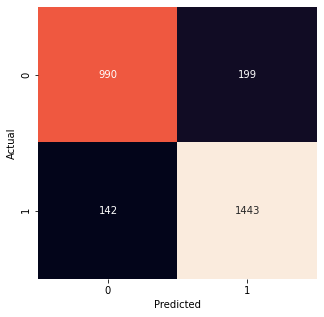

In [35]:
# Creating confusion matrix and classification report for the model
con_mat = confusion_matrix(y_test, y_pred)
creport = classification_report(y_test, y_pred)
print("Classification Report for Support Vector Machine Model:\n{}".format(creport))

# Plotting the results
fig, ax = plt.subplots(figsize=(5,5))
sn.heatmap(con_mat, annot=True, cbar = False, fmt = 'd')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Performance Comparison and Evaluation Strategies

I have used accuracy scores, confusion matrix and a classification report above to evaluate certain classifiers and below I'll be creating k-fold cross validation to evaluate different classification models.

According to __the accuracy score__, __Linear SVC__ is performing the best with __87.7%__ accuracy followed by __SGD classifier__ with __87.4%__ accuracy and then __Logistic Regression__ model with __85.4%__ accuracy.

According to the __classification report__ which shows precision, recall, F1 score and support values, SGD classifier and SVC classifier are performing equally well with good values of negative and positive review prediction as shown by precision/recall scores ranging from 85%-90%

Precision helps in measuring the exactness of a classifier because it measures how well the false positives are getting reduced through the model. Whereas Recall measures the completeness where it is more inclined towards measuring false negatives. Thus F1-Score is a good measure which gives equal weightage to both precision and recall and helps in evaluating a text classifier from both perspectives. Thus, SVC shows the highest F1-Score followed by SGD and logistic regression.

On the other hand, Confusion matrix is showing the similar classification report data in terms of exact numbers.

__Cross Validation__ <br>
Let's see how well the classifier works with cross validation which is a great strategy in performance evaluation because it helps in minimising the chance of overfitting.

In [36]:
# 10-Fold Cross Validation
svc_model = LinearSVC()
cv_acc = cross_val_score(svc_model, X_train, y_train, cv=10, scoring="accuracy")

folds = [ "Fold %d ->" % i for i in range(1,len(cv_acc)+1) ]
acc_series = pd.Series(cv_acc, index = folds)
print(acc_series)

print("Mean accuracy for SVC using 10-Fold CV-> %.4f" % acc_series.mean() )

Fold 1 ->     0.873261
Fold 2 ->     0.880989
Fold 3 ->     0.890263
Fold 4 ->     0.897991
Fold 5 ->     0.896445
Fold 6 ->     0.877898
Fold 7 ->     0.871716
Fold 8 ->     0.882535
Fold 9 ->     0.884080
Fold 10 ->    0.896445
dtype: float64
Mean accuracy for SVC using 10-Fold CV-> 0.8852


In [37]:
# 10-Fold Cross Validation
sgd_model = SGDClassifier()
cv_acc = cross_val_score(sgd_model, X_train, y_train, cv=10, scoring="accuracy")

folds = [ "Fold %d ->" % i for i in range(1,len(cv_acc)+1) ]
acc_series = pd.Series(cv_acc, index = folds)
print(acc_series)

print("Mean accuracy for SGD using 10-Fold CV-> %.4f" % acc_series.mean() )

Fold 1 ->     0.876352
Fold 2 ->     0.879444
Fold 3 ->     0.888717
Fold 4 ->     0.890263
Fold 5 ->     0.888717
Fold 6 ->     0.882535
Fold 7 ->     0.862442
Fold 8 ->     0.882535
Fold 9 ->     0.876352
Fold 10 ->    0.890263
dtype: float64
Mean accuracy for SGD using 10-Fold CV-> 0.8818


The mean accuracy results from 10-Fold Cross Validation also shows that SVC is the best performing classifier followed by SGD classifier.

### Task 3 - Review Helpfulness Classification:

In this task, I will build two classifiers to distinguish between "Helpful" and "Unhelpful" reviews.

In the pre-processing steps above, I have already created a numeric representation of text documents where I assigned Helpfulness information as labels.

In [38]:
helpfulness_df.head(5)

,00004,00004 brita,0014,0014 sodastream,00373,00373 water,00377,00377 assumes,018,018 water,...,zoloft really,zone,zp,zp bowl,zp canned,zp close,zp figuring,zucchini,zukes,Label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Helpful
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Helpful
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Unhelpful
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Helpful
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Unhelpful


__Training and Testing Datasets__

Using `train_test_split` function with a splitting criteria of 70%-30% to generate training and testing datasets for the helpfulness classification.

In [39]:
X_train, X_test, y_train, y_test = train_test_split(helpfulness_df.iloc[:,:-1], helpfulness_df.iloc[:,-1], test_size=0.30)


Reviewing the distribution of labels within the training dataset

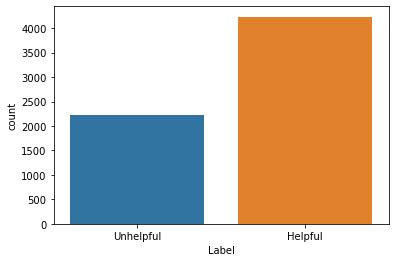

In [40]:
sn.countplot(y_train)
plt.show()

__Building Classification Models__

Generating models using multiple classification algorithms together and then plotting accuracy results to see which one performs better. 
- Random Forest
- K Nearest Neighbours
- Linear Support Vector
- Decision Tree
- Multinomial Naive Bayes
- Logictic Regression

Note: Running the below step would take a few minutes (6-7 minutes) because it trains and calculates the accuracy for various classification models together

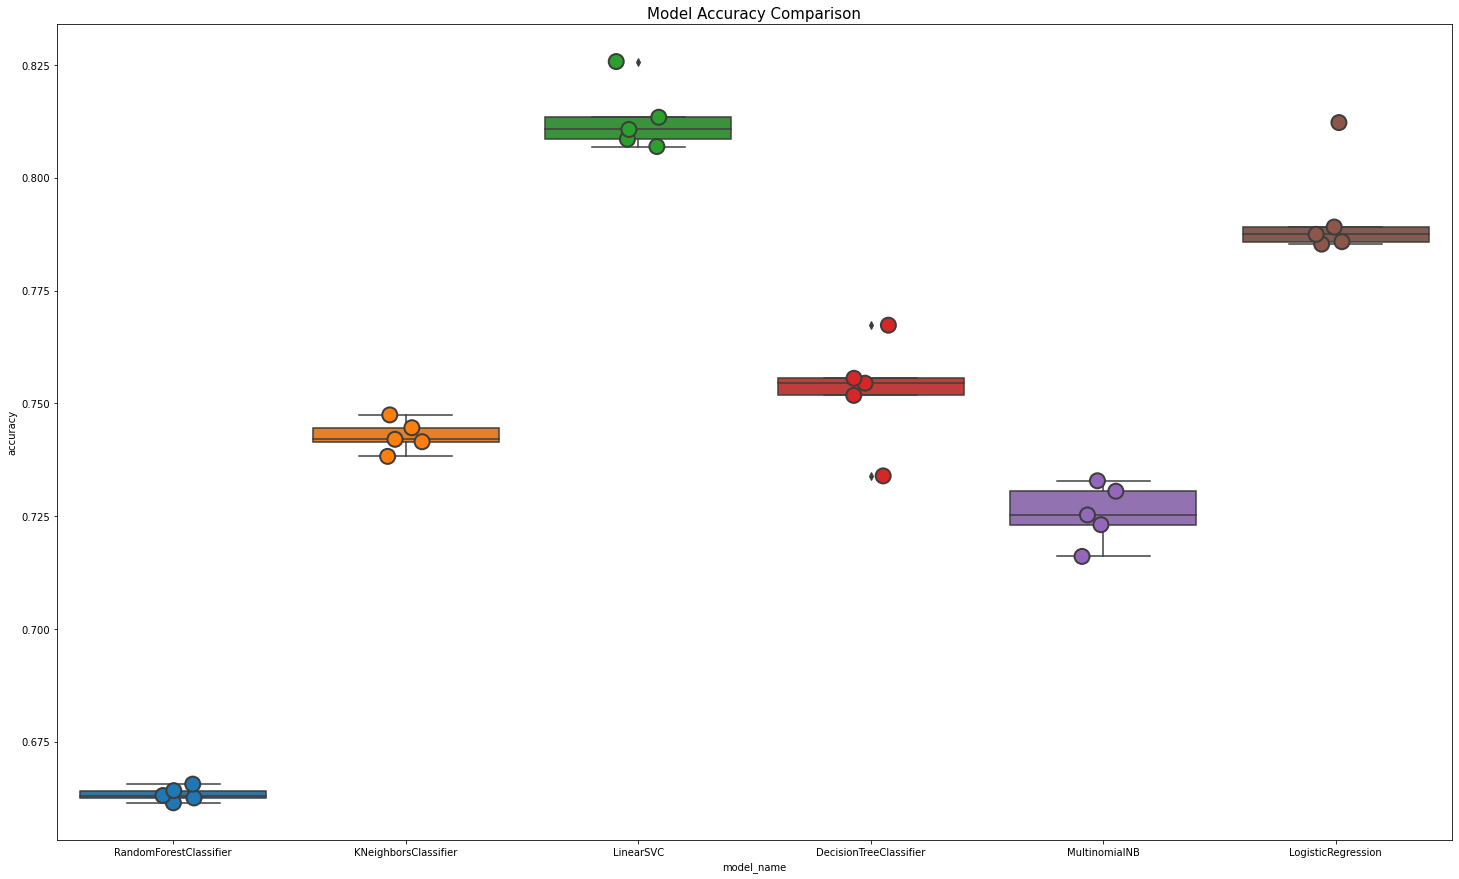

In [41]:
cvdf = classifier_mixup(helpfulness_df)

In [42]:
# Mean accuarcy per model
cvdf.groupby('model_name').accuracy.mean()

model_name
DecisionTreeClassifier    0.752598
KNeighborsClassifier      0.742752
LinearSVC                 0.813069
LogisticRegression        0.791975
MultinomialNB             0.725552
RandomForestClassifier    0.663349
Name: accuracy, dtype: float64

The plot and the mean accuracy table above shows that the __Linear Support Vector Machine__ performs best amongst all the models followed by __Logistic Regression__ Model.

__Logistic Regression Model__

It uses weighted combination of features and then passes it into the sigmoid function.

In [43]:
# Building and training the classifier
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

# Testing the classifier
y_pred = lr_model.predict(X_test)

# Accuracy
chk_acc = accuracy_score(y_pred, y_test)
print('Accuracy Score with Logistic Regression:{} \n'.format(chk_acc*100))

Accuracy Score with Logistic Regression:79.1636625811103 



Classification Report for Logistic Regression Model:
              precision    recall  f1-score   support

     Helpful       0.79      0.93      0.85      1828
   Unhelpful       0.80      0.52      0.63       946

    accuracy                           0.79      2774
   macro avg       0.79      0.73      0.74      2774
weighted avg       0.79      0.79      0.78      2774



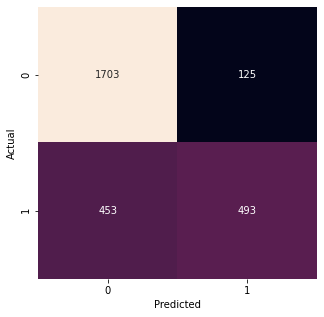

In [44]:
# Creating confusion matrix and classification report for the model
con_mat = confusion_matrix(y_test, y_pred)
creport = classification_report(y_test, y_pred)
print("Classification Report for Logistic Regression Model:\n{}".format(creport))

# Plotting the results
fig, ax = plt.subplots(figsize=(5,5))
sn.heatmap(con_mat, annot=True, cbar = False, fmt = 'd')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

__Linear Stochastic Gradient Descent__

Linear SGD and Linear SVC are widely considered as the best text classification algorithms. It is so because text is often linearly separable and they have a lot of features making it high dimension.

In [45]:
# Building and training the classifier
sgd_model = SGDClassifier()
sgd_model.fit(X_train, y_train)

# Testing the classifier
y_pred = sgd_model.predict(X_test)

# Accuracy
chk_acc = accuracy_score(y_pred, y_test)
print('Accuracy Score with Linear SGD:{} \n'.format(chk_acc*100))

Accuracy Score with Linear SGD:80.49747656813267 



Using `Pipeline` to implement the SGD classification model which uses different pre processing techniques as `Count Vectorizer` and `TF-IDF Transformer`

In [46]:
pipeline_sgd = Pipeline([('vec', CountVectorizer(stop_words="english")),
                    ('tfidf', TfidfTransformer(use_idf=True)),
                    ('clf', SGDClassifier())
                    ])
acc_scores = cross_val_score(pipeline_sgd, lemmatized_df.iloc[:,0], lemmatized_df.iloc[:,2],
cv=10, scoring="accuracy")

print("Overall mean accuracy with Linear SGD:%.2f" %acc_scores.mean())

Overall mean accuracy with Linear SGD:0.81


Both general SGD classifier and the pipeline implementation for sgd classifiers are performing similarly in terms of their accuracy scores.

Classification Report for SGD Classification Model:
              precision    recall  f1-score   support

     Helpful       0.84      0.87      0.85      1828
   Unhelpful       0.73      0.68      0.70       946

    accuracy                           0.80      2774
   macro avg       0.79      0.77      0.78      2774
weighted avg       0.80      0.80      0.80      2774



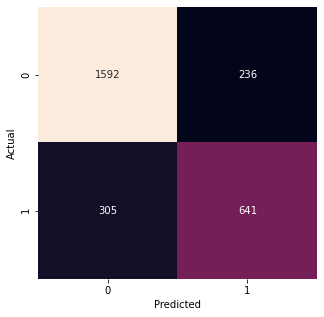

In [47]:
# Creating confusion matrix and classification report for the model
con_mat = confusion_matrix(y_test, y_pred)
creport = classification_report(y_test, y_pred)
print("Classification Report for SGD Classification Model:\n{}".format(creport))

# Plotting the results
fig, ax = plt.subplots(figsize=(5,5))
sn.heatmap(con_mat, annot=True, cbar = False, fmt = 'd')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

__Linear Support Vector Machine__

In [48]:
# Building and training the classifier
svc_model = LinearSVC()
svc_model.fit(X_train, y_train)

# Testing the classifier
y_pred = svc_model.predict(X_test)

# Accuracy
chk_acc = accuracy_score(y_pred, y_test)
print('Accuracy Score with Linear Support Vector Machine:{} \n'.format(chk_acc*100))

Accuracy Score with Linear Support Vector Machine:80.49747656813267 



Classification Report for Support Vector Machine Model:
              precision    recall  f1-score   support

     Helpful       0.84      0.87      0.85      1828
   Unhelpful       0.73      0.67      0.70       946

    accuracy                           0.80      2774
   macro avg       0.79      0.77      0.78      2774
weighted avg       0.80      0.80      0.80      2774



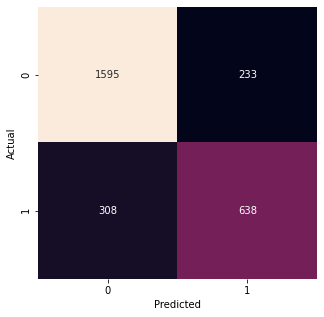

In [49]:
# Creating confusion matrix and classification report for the model
con_mat = confusion_matrix(y_test, y_pred)
creport = classification_report(y_test, y_pred)
print("Classification Report for Support Vector Machine Model:\n{}".format(creport))

# Plotting the results
fig, ax = plt.subplots(figsize=(5,5))
sn.heatmap(con_mat, annot=True, cbar = False, fmt = 'd')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

__Decision Tree Classifier__

In [50]:
pipeline_dtc = Pipeline([('vec', CountVectorizer(stop_words="english")),
                    ('tfidf', TfidfTransformer(use_idf=True)),
                    ('clf', DecisionTreeClassifier())
                    ])

acc_scores = cross_val_score(pipeline_dtc, lemmatized_df.iloc[:,0], lemmatized_df.iloc[:,2],
cv=10, scoring="accuracy")

print("Overall mean accuracy:%.2f" %acc_scores.mean())


Overall mean accuracy:0.76


### Performance Comparison and Evaluation Strategies

I have used accuracy scores, confusion matrix and a classification report above to evaluate certain classifiers and below I'll be creating k-fold cross validation to evaluate different classification models.

According to __the accuracy score__, __SGD Classifier__ is performing the best with __81%__ accuracy followed by __Linear SVC__ with __80.5%__ accuracy and then __Logistic Regression__ and __Decision Tree__ models with __79%__ & __76%__ accuracy.

According to the __classification report__ which shows precision, recall, F1 score and support values, SGD classifier and SVC classifier are performing equally well with good values of negative and positive review prediction as shown by precision/recall scores ranging from 70%-90%

Precision helps in measuring the exactness of a classifier because it measures how well the false positives are getting reduced through the model. Whereas Recall measures the completeness where it is more inclined towards measuring false negatives. Thus F1-Score is a good measure which gives equal weightage to both precision and recall and helps in evaluating a text classifier from both perspectives. Thus, SVC shows the highest F1-Score followed by SGD and logistic regression.

On the other hand, Confusion matrix is showing the similar classification report data in terms of exact numbers.

__Cross Validation__ <br>
Let's see how well the classifier works with cross validation which is a great strategy in performance evaluation because it helps in minimising the chance of overfitting.

In [51]:
# 10-Fold Cross Validation
svc_model = LinearSVC()
cv_acc = cross_val_score(svc_model, X_train, y_train, cv=10, scoring="accuracy")

folds = [ "Fold %d ->" % i for i in range(1,len(cv_acc)+1) ]
acc_series = pd.Series(cv_acc, index = folds)
print(acc_series)

print("Mean accuracy for SVC using 10-Fold CV-> %.4f" % acc_series.mean() )

Fold 1 ->     0.839258
Fold 2 ->     0.788253
Fold 3 ->     0.817620
Fold 4 ->     0.808346
Fold 5 ->     0.795981
Fold 6 ->     0.831530
Fold 7 ->     0.828439
Fold 8 ->     0.789799
Fold 9 ->     0.811437
Fold 10 ->    0.823802
dtype: float64
Mean accuracy for SVC using 10-Fold CV-> 0.8134


In [52]:
# 10-Fold Cross Validation
sgd_model = SGDClassifier()
cv_acc = cross_val_score(sgd_model, X_train, y_train, cv=10, scoring="accuracy")

folds = [ "Fold %d ->" % i for i in range(1,len(cv_acc)+1) ]
acc_series = pd.Series(cv_acc, index = folds)
print(acc_series)

print("Mean accuracy for SGD using 10-Fold CV-> %.4f" % acc_series.mean() )

Fold 1 ->     0.826893
Fold 2 ->     0.777434
Fold 3 ->     0.822257
Fold 4 ->     0.800618
Fold 5 ->     0.791345
Fold 6 ->     0.837713
Fold 7 ->     0.816074
Fold 8 ->     0.791345
Fold 9 ->     0.806801
Fold 10 ->    0.814529
dtype: float64
Mean accuracy for SGD using 10-Fold CV-> 0.8085


The mean accuracy results from 10-Fold Cross Validation also shows that SVC is the best performing classifier followed by SGD classifier.

### Difference in performance of the two classification tasks:

- Overall accuracy score shows that sentiment classification works better than the helpfulness classification because the accuracy reaches around 88% for sentiment classification models whereas it is 80% with the helpfulness classification.
- Multinomial Naive Bayes which is a good algorithm for text classification performs better with sentiment classification whereas there is a dip of 10% with the helpfulness classification.
- In both the classification tasks, Support Vector Machine is the best performing algorithm overall.
- While performing cross validation on multiple classifiers, sentiment classification shows almost similar accuracy scores in all the folds but helpfulness classification shows good amount of variation in accuracy scores. Hence, cross validation proves to be good evaluation technique in helpfulness classification because hold out strategy could lead to overfitting.
- Also on comparing the classification metrics (Precision, Recall, F1-Score) of both the classification tasks, we see that Sentiment classification performs better.

## Conclusion:

### Summary of Insights:

- Large amount of reviews are scraped with the help of Beautiful Soup Parser.
- Review information was extracted using various different tags within the HTML code such as anchor tags, headings, href tags etc.
- Based on the number of rating, the target class was decided for the sentiment classification. Similarly, based on the percentage of helpfulness, the target class was assigned for the helpfulness classification.
- A number of pre-processing steps are performed over text reviews such as normalisation, lemmatisation, stop word removal, tf-idf vectorization and tf-idf transformation which resulted in good formation of the dataset.
- Many different classification algorithms are tried on both the sentiment and helpfulness data to decide on the best classification strategies. Models such as:
    1. Random Forest
    2. K Nearest Neighbours
    3. Linear Support Vector
    4. Decision Tree
    5. Multinomial Naive Bayes
    6. Logistic Regression
- Support Vector Machine classifier is the best performing model in both the tasks.
- Other good performing classifiers are Stochastic Gradient Descent and the logistic regression models.
- Sentiment Classification showed highest accuracy as 88% whereas Helpfulness classification showed highest accuracy as 81%
- SGD Pipeline strategy shows almost similar results as the general SGD classifier.
- Classification report showed a wide overview on how different labels are getting classified.
- Confusion Matrix helped in unfolding the exact numbers of False Positives and False Negatives.
- Cross Validation proved to be a better evaluation strategy in performance comparison and a better technique to reduce the chance of overfitting.

### Challenges:

- One particular challenge of the review parsing was that there were multiple metadata tags within the HTML so I had to perform some cleaning procedures while fetching the helpfulness information from the webpages. Also, reviews were distributed across multiple pages (30 per page), so I had to iterate through all the pages because index page only had the first page reference for each month and year.
- Another challenge was in deciding the pre processing techniques because multiple cleaning ways had to be adopted to baseline the text data.
- Coming up with a good evaluation strategy was also a major challenge. I calculates various scores using different methods to perfectly come up to a conclusion in terms of best classifier.

### Future Work:

- __Word2Vec__ can be applied which allows mapping of similar meaning words to have similar vector matrix.
- Usage of different similarity techniques like cosine similarity and other distance matrix ways could help in enhancing the classification results.
- GridSearchCV can also be adopted to perform different configurations of the same classification algorithm.
